In [2]:
def list_files(path):
    # returns a list of names (with extension, without full path) of all files 
    # in folder path
    files = []
    for name in os.listdir(path):
        if os.path.isfile(os.path.join(path, name)):
            files.append(name)
    return files

training_data_folder = "/Users/Lena/Documents/DATA/NucleiSegmentationDL/"


In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = training_data_folder+'/stage1_train/'
TEST_PATH = training_data_folder+'/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


Using TensorFlow backend.


In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
len(test_ids)

65

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

Getting and resizing train images and masks ... 


In [7]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

100%|██████████| 670/670 [03:46<00:00,  2.95it/s]


In [8]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 39.52it/s]

Done!


In [9]:
X_train.shape

(670, 128, 128, 3)

In [10]:
Y_train.shape

(670, 128, 128, 1)

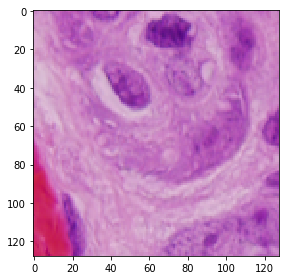

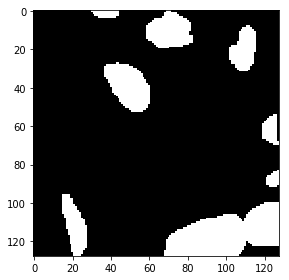

In [11]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [12]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [13]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, 'accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 128, 128, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 16)  448         lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128, 128, 16)  0           conv2d_1[0][0]                   
___________________________________________________________________________________________

In [14]:

# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/Users/Lena/Documents/DATA/NucleiSegmentationDL/u_net_model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 304s - loss: 0.4100 - mean_iou: 0.4097 - acc: 0.8323 - val_loss: 0.3022 - val_mean_iou: 0.4289 - val_acc: 0.9175
Epoch 2/50
603/603 [==============================] - 204s - loss: 0.2085 - mean_iou: 0.4821 - acc: 0.9163 - val_loss: 0.1455 - val_mean_iou: 0.5349 - val_acc: 0.9422
Epoch 3/50
603/603 [==============================] - 336s - loss: 0.1422 - mean_iou: 0.5712 - acc: 0.9440 - val_loss: 0.1075 - val_mean_iou: 0.6051 - val_acc: 0.9583
Epoch 4/50
603/603 [==============================] - 380s - loss: 0.1226 - mean_iou: 0.6313 - acc: 0.9523 - val_loss: 0.1073 - val_mean_iou: 0.6513 - val_acc: 0.9585
Epoch 5/50
603/603 [==============================] - 407s - loss: 0.1190 - mean_iou: 0.6668 - acc: 0.9540 - val_loss: 0.0958 - val_mean_iou: 0.6803 - val_acc: 0.9621
Epoch 6/50
603/603 [==============================] - 540s - loss: 0.1037 - mean_iou: 0.6926 - acc: 0.9599 - val_loss: 0

603/603 [==============================] - 257s - loss: 0.0749 - mean_iou: 0.8072 - acc: 0.9706 - val_loss: 0.0681 - val_mean_iou: 0.8084 - val_acc: 0.9727
Epoch 23/50
603/603 [==============================] - 261s - loss: 0.0737 - mean_iou: 0.8097 - acc: 0.9705 - val_loss: 0.0679 - val_mean_iou: 0.8108 - val_acc: 0.9736
Epoch 24/50
603/603 [==============================] - 255s - loss: 0.0739 - mean_iou: 0.8118 - acc: 0.9709 - val_loss: 0.0693 - val_mean_iou: 0.8129 - val_acc: 0.9730
Epoch 25/50
603/603 [==============================] - 260s - loss: 0.0743 - mean_iou: 0.8138 - acc: 0.9703 - val_loss: 0.0681 - val_mean_iou: 0.8148 - val_acc: 0.9724
Epoch 26/50
603/603 [==============================] - 244s - loss: 0.0717 - mean_iou: 0.8159 - acc: 0.9716 - val_loss: 0.0694 - val_mean_iou: 0.8168 - val_acc: 0.9722
Epoch 27/50
603/603 [==============================] - 244s - loss: 0.0743 - mean_iou: 0.8177 - acc: 0.9704 - val_loss: 0.0656 - val_mean_iou: 0.8185 - val_acc: 0.9743
Epoc